In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import textwrap
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from pathlib import Path

os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"
client = OpenAI()

## Data cleaning
- source1: https://www.kaggle.com/datasets/kshitizregmi/jobs-and-job-description. 
- source2: https://www.kaggle.com/datasets/andrewmvd/data-scientist-jobs (DS specific)

In [13]:
print(os.listdir("../data"))

df_main = pd.read_csv("../data/job_title_des.csv")
df_ds   = pd.read_csv("../data/DataScientist.csv")


['DataScientist.csv', 'job_title_des.csv']


In [17]:
df_main = df_main.rename(columns={
    "Job Title": "title",
    "Job Description": "description"
})

df_ds = df_ds.rename(columns={
    "Job Title": "title",
    "Job Description": "description"
})

In [18]:
df_main = df_main[["title", "description"]].dropna()
df_ds   = df_ds[["title", "description"]].dropna()

In [21]:
# Merge two data
df_all = pd.concat([df_main, df_ds], ignore_index=True)
print(df_all.shape)
df_all["job_id"] = df_all.index
df_all.head()

(6186, 2)


,title,description,job_id
0,Flutter Developer,We are looking for hire experts flutter develo...,0
1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...,1
2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n...",2
3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...,3
4,Full Stack Developer,job responsibility full stack engineer – react...,4


In [ ]:
jobs_df = df_all.copy()
jobs_df.head()

,title,description,job_id
0,Flutter Developer,We are looking for hire experts flutter develo...,0
1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...,1
2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n...",2
3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...,3
4,Full Stack Developer,job responsibility full stack engineer – react...,4


## Take ~2000 sample for FT, we do not need all of them

In [ ]:
TARGET_TOTAL = 1000

# 看有多少種類的 title
unique_titles = jobs_df["title_lower"].unique()
n_titles = len(unique_titles)
print(n_titles)

# 計算每個 title 要抽多少
samples_per_title = 1

sampled_rows = (
    jobs_df.groupby("title_lower", group_keys=False)
           .apply(lambda g: g.sample(
               n=min(len(g), samples_per_title),  # 避免某些組資料太少
               random_state=42
           ))
)

sampled_rows.shape

2069


/var/folders/mw/qrkc_sls4y3c2hh2cgtystk40000gn/T/ipykernel_2299/1194017777.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  jobs_df.groupby("title_lower", group_keys=False)


(2069, 4)

In [43]:
def split_description_to_sentences(text: str):
    """很粗略的切法：用換行 + 句號切成句子。"""
    if not isinstance(text, str):
        return []

    parts = []
    for line in text.split("\n"):
        line = line.strip()
        if not line:
            continue
        for seg in line.split("."):
            seg = seg.strip()
            if len(seg.split()) >= 5:
                parts.append(seg)
    return parts

# Use OpenAI API to generate pseudo bullet points for fine-tuning
def generate_bullets_for_job_openai(title: str,
                                    description: str,
                                    n_bullets: int = 3) -> list[str]:
    """
    使用 OpenAI GPT 模型，根據 job title + description 生成 n_bullets 個履歷 bullets。

    回傳: list[str]，每個元素是一條 bullet（不含前面的符號）。
    """

    system_prompt = (
        "You are generating high-quality resume bullet points for a strong candidate "
        "who is applying to the following role. "
        "Write concise, impactful bullets that could realistically appear on a "
        "Data / ML / Software engineer resume."
    )

    user_prompt = f"""
    JOB TITLE:
    {title}

    JOB DESCRIPTION:
    {description}

    Please write {n_bullets} distinct resume bullet points in English.
    Requirements:
    - Each bullet should start with a strong verb (e.g., Built, Designed, Led, Implemented).
    - Each bullet should describe a specific project, responsibility, or impact that matches the job.
    - When possible, include concrete tools (e.g., Python, SQL, TensorFlow, Docker) and one metric
      (e.g., improved accuracy by 10%, reduced latency by 30%).
    - Do NOT use first person ("I") and do NOT mention the company name.
    - Output format: one bullet per line, each starting with "- ".
    """

    user_prompt = textwrap.dedent(user_prompt).strip()

    response = client.chat.completions.create(
        model="gpt-4.1-mini",  # 或你喜歡的模型
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0.7,
    )

    text = response.choices[0].message.content.strip()

    bullets = []
    for line in text.splitlines():
        line = line.strip()
        if line.startswith("- "):
            bullets.append(line[2:].strip())
        elif line.startswith("• "):
            bullets.append(line[2:].strip())
    if not bullets:
        bullets = [f"Contributed as a {title} on data-related projects."]
    return bullets


def add_pseudo_bullets(df: pd.DataFrame,
                       bullets_per_job: int = 3) -> pd.DataFrame:

    all_bullets = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating bullets (OpenAI)"):
        bullets = generate_bullets_for_job_openai(
            row["title"],
            row["description"],
            n_bullets=bullets_per_job
        )
        all_bullets.append(bullets)

    df["bullets"] = all_bullets
    return df

jobs_df = add_pseudo_bullets(sampled_rows)
jobs_df.head()


Generating bullets (OpenAI): 100%|██████████| 2069/2069 [1:09:26<00:00,  2.01s/it]


,title,description,job_id,title_lower,bullets
4652,#104733 HPC Systems and Data Engineer,The effects of the COVID-19 pandemic have impa...,4652,#104733 hpc systems and data engineer,[Administered and optimized large-scale HPC cl...
4575,#105054 (CLS) Clinical Lab Scientist - Microbi...,This is a UC San Diego Internal Recruitment op...,4575,#105054 (cls) clinical lab scientist - microbi...,[Executed complex microbiological assays and s...
4564,(CLS) Clinical Lab Scientist - Microbiology,This is a UC San Diego Internal Recruitment op...,4564,(cls) clinical lab scientist - microbiology,[Conducted comprehensive microbiology testing ...
3792,(Data Analyst) BA/BSA,Job Title: (Data Analyst) BA/BSA\nJob Location...,3792,(data analyst) ba/bsa,[Developed interactive Tableau dashboards to v...
5956,(Data Risk Analyst: Data Modeler),PRIMARY DUTIES & KEY RESPONSIBILITIES(Primary ...,5956,(data risk analyst: data modeler),[Developed and validated credit risk models us...


In [45]:
jobs_df.sample(5)[["title", "bullets"]]

,title,bullets
3730,Pre-Clinical Imaging Field Application Scientist,[Delivered advanced training sessions and appl...
2482,Sr. Data Scientist II,[Developed and deployed advanced machine learn...
4513,"Scientist, GPCR Molecular and Cellular Pharmac...",[Developed and optimized cutting-edge FRET and...
4194,"Senior Scientist, Assay Operations",[Developed and optimized high-throughput bioch...
3371,Pipeline Integrity – Data Scientist,[Developed and implemented data pipelines usin...


In [46]:
jobs_df.to_csv("../data/jobs_with_bullets.csv", index=False, encoding="utf-8")

## Generate questions for each bullet point

In [50]:
def generate_questions_for_bullet_openai(bullet: str, n_questions: int = 1) -> list[str]:
    """
    使用 OpenAI GPT 依據一條履歷 bullet 生成面試官可能會問的問題。
    回傳: list[str]，每個元素是一個 question。
    """
    system_prompt = (
        "You are an experienced interviewer for Data Science / Machine Learning / "
        "Software Engineering roles. Given a resume bullet point, you will propose "
        "interview questions that dig deeper into that specific experience."
    )

    user_prompt = f"""
    Here is a resume bullet point:

    "{bullet}"

    Please write {n_questions} distinct interview-style questions that you might ask
    a candidate about this experience. Requirements:
    - Use conversational, realistic interview language.
    - Focus on understanding the candidate's role, decisions, and impact.
    - Prefer behavioral / project-focused questions (how they built it, why, challenges, results).
    - Do NOT reference the word "bullet" or "resume" in the question.
    - Output format: one question per line, each starting with "- ".
    """

    user_prompt = textwrap.dedent(user_prompt).strip()

    try:
        response = client.chat.completions.create(
            model="gpt-4.1-mini",  # 或 gpt-4.1 / gpt-4o-mini 看你要的品質 & 成本
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            temperature=0.7,
        )

        text = response.choices[0].message.content.strip()
        questions = []
        for line in text.splitlines():
            line = line.strip()
            if line.startswith("- "):
                questions.append(line[2:].strip())
        # fallback：如果沒照格式，就全部當一行，或給 fallback 問題
        if not questions:
            questions = [f"Can you walk me through this experience: {bullet}?"]
        return questions[:n_questions]

    except Exception as e:
        print(f"[WARN] OpenAI question generation failed: {e}")
        # 失敗時 fallback 用原本 dummy 函數邏輯
        base = bullet.strip()
        if not base:
            base = "this experience"
        q1 = f"Can you walk me through a time when you worked on {base}?"
        return [q1][:n_questions]


def build_bullet_and_question_tables(df: pd.DataFrame,
                                     questions_per_bullet: int = 1):
    bullet_records = []
    q_records = []
    bullet_id = 0

    for _, row in df.iterrows():
        job_id = row["job_id"]
        desc = row["description"]
        for b in row["bullets"]:
            bullet_records.append({
                "bullet_id": bullet_id,
                "job_id": job_id,
                "bullet": b,
                "job_description": desc
            })
            qs = generate_questions_for_bullet_openai(b, n_questions=questions_per_bullet)
            for q in qs:
                q_records.append({
                    "bullet_id": bullet_id,
                    "job_id": job_id,
                    "question": q
                })
            bullet_id += 1

    bullets_df = pd.DataFrame(bullet_records)
    q_df = pd.DataFrame(q_records)
    print(f"Total bullets: {len(bullets_df)}, total (question, bullet) pairs: {len(q_df)}")
    return bullets_df, q_df

In [51]:
bullets_df, q_df = build_bullet_and_question_tables(jobs_df)
bullets_df.head(), q_df.head()

Total bullets: 6207, total (question, bullet) pairs: 6207


(   bullet_id  job_id                                             bullet  \
 0          0    4652  Administered and optimized large-scale HPC clu...   
 1          1    4652  Integrated and maintained high-speed interconn...   
 2          2    4652  Developed and automated Linux system administr...   
 3          3    4575  Executed complex microbiological assays and sp...   
 4          4    4575  Developed and optimized laboratory protocols a...   
 
                                      job_description  
 0  The effects of the COVID-19 pandemic have impa...  
 1  The effects of the COVID-19 pandemic have impa...  
 2  The effects of the COVID-19 pandemic have impa...  
 3  This is a UC San Diego Internal Recruitment op...  
 4  This is a UC San Diego Internal Recruitment op...  ,
    bullet_id  job_id                                           question
 0          0    4652  Can you walk me through a specific challenge y...
 1          1    4652  Can you walk me through a specific p

In [54]:
q_df.to_csv("../data/generated_question.csv", index=False, encoding="utf-8")
bullets_df.to_csv("../data/bullet_jd.csv", index=False, encoding="utf-8")


## Train/Test split
pairs (JD+Question) to bullet point

In [6]:
bullets_df = pd.read_csv("../data/bullet_jd.csv")
q_df = pd.read_csv("../data/generated_question.csv")

In [7]:
bullets_df

,bullet_id,job_id,bullet,job_description
0,0,4652,Administered and optimized large-scale HPC clu...,The effects of the COVID-19 pandemic have impa...
1,1,4652,Integrated and maintained high-speed interconn...,The effects of the COVID-19 pandemic have impa...
2,2,4652,Developed and automated Linux system administr...,The effects of the COVID-19 pandemic have impa...
3,3,4575,Executed complex microbiological assays and sp...,This is a UC San Diego Internal Recruitment op...
4,4,4575,Developed and optimized laboratory protocols a...,This is a UC San Diego Internal Recruitment op...
...,...,...,...,...
6202,6202,2914,Conducted comprehensive materials and device c...,Requisition ID: 55262\n\nAll Locations: El Seg...
6203,6203,2914,Led creation of custom software tools for auto...,Requisition ID: 55262\n\nAll Locations: El Seg...
6204,6204,3434,Analyzed and validated pipeline DGPS data usin...,"Description\n\nROSEN USA, based in Houston, TX..."
6205,6205,3434,Executed reference and marker setup by correla...,"Description\n\nROSEN USA, based in Houston, TX..."


In [8]:
train_bullet_ids, test_bullet_ids = train_test_split(
    bullets_df["bullet_id"].unique(), test_size=0.2
)

bullets_df_train = bullets_df[bullets_df["bullet_id"].isin(train_bullet_ids)]
q_df_train       = q_df[q_df["bullet_id"].isin(train_bullet_ids)]

bullets_df_test  = bullets_df[bullets_df["bullet_id"].isin(test_bullet_ids)]
q_df_test        = q_df[q_df["bullet_id"].isin(test_bullet_ids)]

## Base model: sentencetransformer all-MiniLM-L6-v2
https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [12]:
from sentence_transformers import SentenceTransformer, InputExample, losses, util
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

base_model = SentenceTransformer(BASE_MODEL_NAME, device=DEVICE)
base_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## Define evaluation metric

Query:
Job description:\n{jd_text}\n\nInterview question:\n{q_text}

Retrieve:
certain bullet point

In [15]:
def evaluate_jd_plus_question_to_bullet(model: SentenceTransformer,
                                        bullets_df: pd.DataFrame,
                                        q_df: pd.DataFrame,
                                        ks=(1, 3, 5, 10)):
    """
    Evaluate retrieval for the true use case:
    Given (job_description + interview question) as query,
    can the model retrieve the correct bullet from all bullets?

    bullets_df: 包含至少 ['bullet_id', 'job_id', 'bullet', 'job_description']
    q_df:       包含至少 ['bullet_id', 'job_id', 'question']
    """

    # 1. 準備所有 candidate bullets 的 embedding（一次算好）
    all_bullets = bullets_df["bullet"].tolist()
    all_bullet_ids = bullets_df["bullet_id"].tolist()
    bullet_embs = model.encode(
        all_bullets,
        convert_to_tensor=True,
        show_progress_bar=True
    )

    # 2. 建 job_id -> job_description 對應表（用來組 query）
    job_id2desc = (
        bullets_df[["job_id", "job_description"]]
        .drop_duplicates()
        .set_index("job_id")["job_description"]
        .to_dict()
    )

    hits = {k: 0 for k in ks}
    precision = {k: 0.0 for k in ks}

    # 3. 逐行 query： (JD + question) -> retrieve bullet
    for _, row in tqdm(q_df.iterrows(),
                       total=len(q_df),
                       desc="Eval (JD + question) -> bullet"):
        q_text = row["question"]
        job_id = row["job_id"]
        true_bullet_id = row["bullet_id"]

        # 安全拿到對應的 JD
        jd_text = job_id2desc.get(job_id, "")

        # 把 JD + question 組成一個 query
        query_text = f"Job description:\n{jd_text}\n\nInterview question:\n{q_text}"

        q_emb = model.encode(query_text, convert_to_tensor=True)
        cos_scores = util.cos_sim(q_emb, bullet_embs)[0]   # shape: (n_bullets,)

        # 取 top-k（完全用 torch，不轉 numpy）
        top_indices_tensor = torch.topk(cos_scores, k=max(ks)).indices.cpu()
        top_indices = top_indices_tensor.tolist()  # 變成 Python list[int]
        top_bullet_ids = [all_bullet_ids[i] for i in top_indices]

        # 統計 Hit@k / Precision@k
        for k in ks:
            topk_ids = top_bullet_ids[:k]
            if true_bullet_id in topk_ids:
                hits[k] += 1
                precision[k] += 1.0 / k
            else:
                precision[k] += 0.0

    n_queries = len(q_df)
    results = {}
    for k in ks:
        results[k] = {
            "Hit@k": hits[k] / n_queries,
            "Precision@k": precision[k] / n_queries
        }

    print("=== Retrieval: (JD + question) -> bullet ===")
    for k in ks:
        print(f"k={k}: Hit@k={results[k]['Hit@k']:.4f}, "
              f"Precision@k={results[k]['Precision@k']:.4f}")
    return results

## Baseline Performance

In [83]:
baseline = evaluate_jd_plus_question_to_bullet(base_model, bullets_df_test, q_df_test)
baseline

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:24<00:00, 51.17it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.2174, Precision@k=0.2174
k=3: Hit@k=0.3253, Precision@k=0.1084
k=5: Hit@k=0.3776, Precision@k=0.0755
k=10: Hit@k=0.4485, Precision@k=0.0448


{1: {'Hit@k': 0.21739130434782608, 'Precision@k': 0.21739130434782608},
 3: {'Hit@k': 0.3252818035426731, 'Precision@k': 0.10842726784755725},
 5: {'Hit@k': 0.3776167471819646, 'Precision@k': 0.07552334943639355},
 10: {'Hit@k': 0.44847020933977455, 'Precision@k': 0.044847020933977876}}

## Fine-tuning

In [8]:
def build_finetune_pairs_jdq_to_bullet(bullets_df: pd.DataFrame,
                                       q_df: pd.DataFrame) -> pd.DataFrame:
    """
    建立 fine-tune 用的 pair：
    Query:  job_description + question
    Target: bullet
    """

    # 1. 合併 question 資訊到 bullet 上
    merged = q_df.merge(
        bullets_df,
        on=["bullet_id", "job_id"],
        suffixes=("_q", "_b")
    )
    # merged 會有欄位：bullet_id, job_id, question, bullet, job_description ...

    # 2. 組 query_text：JD + 問題
    merged["query_text"] = (
        "JOB DESCRIPTION:\n" +
        merged["job_description"].astype(str) +
        "\n\nINTERVIEW QUESTION:\n" +
        merged["question"].astype(str)
    )

    train_pairs = merged[["query_text", "bullet"]].copy()
    print("Total fine-tuning pairs:", len(train_pairs))
    return train_pairs

train_pairs = build_finetune_pairs_jdq_to_bullet(bullets_df_train, q_df_train)
train_pairs.head()

Total fine-tuning pairs: 4965


,query_text,bullet
0,JOB DESCRIPTION:\nThe effects of the COVID-19 ...,Administered and optimized large-scale HPC clu...
1,JOB DESCRIPTION:\nThe effects of the COVID-19 ...,Integrated and maintained high-speed interconn...
2,JOB DESCRIPTION:\nThis is a UC San Diego Inter...,Developed and optimized laboratory protocols a...
3,JOB DESCRIPTION:\nThis is a UC San Diego Inter...,Collaborated on research abstracts and manuscr...
4,JOB DESCRIPTION:\nThis is a UC San Diego Inter...,Conducted comprehensive microbiology testing a...


In [ ]:
def finetune_embedding_model_from_pairs(train_pairs: pd.DataFrame,
                                        base_model_name: str = BASE_MODEL_NAME,
                                        epochs: int = 1,
                                        batch_size: int = 16):
    """
    train_pairs 需要有兩
    個欄位：
    - 'query_text'
    - 'bullet'
    """

    model = SentenceTransformer(base_model_name, device=DEVICE)

    train_examples = [
        InputExample(texts=[row["query_text"], row["bullet"]])
        for _, row in train_pairs.iterrows()
    ]

    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
    train_loss = losses.MultipleNegativesRankingLoss(model)

    warmup_steps = int(len(train_dataloader) * epochs * 0.1)

    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=epochs,
        warmup_steps=warmup_steps,
        show_progress_bar=True,
    )

    return model

finetuned_model = finetune_embedding_model_from_pairs(
    train_pairs,
    base_model_name=BASE_MODEL_NAME,
    epochs=1,
    batch_size=16
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/311 [00:00<?, ?it/s]

In [12]:
ft =  evaluate_jd_plus_question_to_bullet(finetuned_model, bullets_df_test, q_df_test)
ft

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:24<00:00, 50.11it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.3454, Precision@k=0.3454
k=3: Hit@k=0.5008, Precision@k=0.1669
k=5: Hit@k=0.5620, Precision@k=0.1124
k=10: Hit@k=0.6554, Precision@k=0.0655


{1: {'Hit@k': 0.34541062801932365, 'Precision@k': 0.34541062801932365},
 3: {'Hit@k': 0.500805152979066, 'Precision@k': 0.16693505099302322},
 5: {'Hit@k': 0.5619967793880838, 'Precision@k': 0.11239935587761725},
 10: {'Hit@k': 0.6553945249597424, 'Precision@k': 0.06553945249597395}}

In [37]:
def finetune_embedding_model_from_pairs(train_pairs: pd.DataFrame,
                                        base_model_name: str = BASE_MODEL_NAME,
                                        epochs: int = 1,
                                        batch_size: int = 16):
    """
    train_pairs 需要有兩個欄位：
    - 'query_text'
    - 'bullet'

    回傳：
    - model: 訓練後的 SentenceTransformer
    - loss_history: 每個 batch 的 loss（長度 = epochs * steps_per_epoch）
    - steps_per_epoch: 每個 epoch 有多少個 batch
    """

    model = SentenceTransformer(base_model_name, device=DEVICE)

    # 準備訓練資料
    train_examples = [
        InputExample(texts=[row["query_text"], row["bullet"]])
        for _, row in train_pairs.iterrows()
    ]

    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)

    # 建一個會幫我們記錄 loss 的 wrapper
    loss_history = []

    class LoggingMNRLoss(losses.MultipleNegativesRankingLoss):
        def __init__(self, model, buffer):
            super().__init__(model)
            self.buffer = buffer

        def forward(self, sentence_features, labels=None):
            loss = super().forward(sentence_features, labels)
            # 記錄每個 batch 的 loss
            self.buffer.append(loss.item())
            return loss

    train_loss = LoggingMNRLoss(model, loss_history)

    warmup_steps = int(len(train_dataloader) * epochs * 0.1)

    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=epochs,
        warmup_steps=warmup_steps,
        show_progress_bar=True,
    )

    steps_per_epoch = len(train_dataloader)
    return model, loss_history, steps_per_epoch

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/311 [00:00<?, ?it/s]

Iteration:   0%|          | 0/311 [00:00<?, ?it/s]

Iteration:   0%|          | 0/311 [00:00<?, ?it/s]

Iteration:   0%|          | 0/311 [00:00<?, ?it/s]

Iteration:   0%|          | 0/311 [00:00<?, ?it/s]

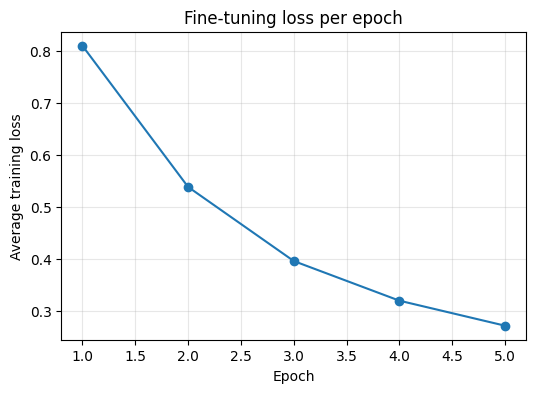

In [38]:
finetuned_model, loss_history, steps_per_epoch = finetune_embedding_model_from_pairs(
    train_pairs,
    base_model_name=BASE_MODEL_NAME,
    epochs=5,          # 你想要幾個 epoch 就改這裡
    batch_size=16
)
E = 5  # 要跟剛剛 epochs 一樣

epoch_losses = []
for ep in range(E):
    start = ep * steps_per_epoch
    end = (ep + 1) * steps_per_epoch
    ep_losses = loss_history[start:end]
    if len(ep_losses) > 0:
        avg_loss = sum(ep_losses) / len(ep_losses)
    else:
        avg_loss = float("nan")
    epoch_losses.append(avg_loss)

plt.figure(figsize=(6,4))
plt.plot(range(1, E+1), epoch_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average training loss")
plt.title("Fine-tuning loss per epoch")
plt.grid(True, alpha=0.3)
plt.show()

In [39]:
ft5 =  evaluate_jd_plus_question_to_bullet(finetuned_model, bullets_df_test, q_df_test)
ft5

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:25<00:00, 48.97it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.3704, Precision@k=0.3704
k=3: Hit@k=0.5370, Precision@k=0.1790
k=5: Hit@k=0.6111, Precision@k=0.1222
k=10: Hit@k=0.6868, Precision@k=0.0687


{1: {'Hit@k': 0.37037037037037035, 'Precision@k': 0.37037037037037035},
 3: {'Hit@k': 0.5370370370370371, 'Precision@k': 0.17901234567901392},
 5: {'Hit@k': 0.6111111111111112, 'Precision@k': 0.12222222222222216},
 10: {'Hit@k': 0.6867954911433173, 'Precision@k': 0.06867954911433126}}

## Comparison

In [48]:
baseline = evaluate_jd_plus_question_to_bullet(
    base_model,
    bullets_df_test,
    q_df_test
)

finetuned = evaluate_jd_plus_question_to_bullet(
    finetuned_model,
    bullets_df_test,
    q_df_test
)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:23<00:00, 52.45it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.2118, Precision@k=0.2118
k=3: Hit@k=0.3124, Precision@k=0.1041
k=5: Hit@k=0.3663, Precision@k=0.0733
k=10: Hit@k=0.4332, Precision@k=0.0433


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:21<00:00, 58.87it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.3704, Precision@k=0.3704
k=3: Hit@k=0.5370, Precision@k=0.1790
k=5: Hit@k=0.6111, Precision@k=0.1222
k=10: Hit@k=0.6868, Precision@k=0.0687


In [54]:
ks = sorted(baseline.keys())
rows = []
for k in ks:
    rows.append({
        "k": k,
        "baseline_Hit@k": baseline[k]["Hit@k"],
        "baseline_P@k":   baseline[k]["Precision@k"],
        "ft_Hit@k":       finetuned[k]["Hit@k"],
        "ft_P@k":         finetuned[k]["Precision@k"],
    })

results_df = pd.DataFrame(rows)
results_df

,k,baseline_Hit@k,baseline_P@k,ft_Hit@k,ft_P@k
0,1,0.211755,0.211755,0.370370,0.370370
1,3,0.312399,0.104133,0.537037,0.179012
2,5,0.366345,0.073269,0.611111,0.122222
3,10,0.433172,0.043317,0.686795,0.068680


## Visualization -> TSNE to 2D mapping

In [9]:
# 從 test set 中抽一些 pairs 來畫圖
N_VIS = 80  # 可調整，你可以先 50~100

vis_q_df = q_df_test.sample(n=N_VIS, random_state=42).copy()

# join 上 bullet / job_description
vis_merged = vis_q_df.merge(
    bullets_df_test,
    on=["bullet_id", "job_id"],
    suffixes=("_q", "_b")
)

vis_merged.head()

,bullet_id,job_id,question,bullet,job_description
0,4549,4516,Can you walk me through how you approached des...,Automated computational workflows with Python ...,"At Lilly, we unite caring with discovery to ma..."
1,5088,2557,Can you walk me through the process you follow...,Developed and implemented advanced causal attr...,The Personalization team makes deciding what t...
2,3569,5726,Can you walk me through the process you design...,Streamlined data ingestion and validation proc...,ABOUT THIS POSITION\n\nWe're looking for a Mar...
3,3346,4184,Can you walk me through the process you follow...,Integrated and transformed multi-source workfo...,In the Global Assessments & People Analytics &...
4,4690,3210,Can you walk me through a specific example of ...,Led troubleshooting and optimization of chroma...,PPD is a leading global contract\nresearch org...


In [10]:
vis_merged["query_text"] = (
    "JOB DESCRIPTION:\n" +
    vis_merged["job_description"].astype(str) +
    "\n\nINTERVIEW QUESTION:\n" +
    vis_merged["question"].astype(str)
)

vis_merged["bullet_text"] = vis_merged["bullet"].astype(str)

In [42]:
texts_query = vis_merged["query_text"].tolist()
texts_bullet = vis_merged["bullet_text"].tolist()

# base model embeddings
base_query_embs = base_model.encode(texts_query, convert_to_tensor=False, normalize_embeddings=True)
base_bullet_embs = base_model.encode(texts_bullet, convert_to_tensor=False, normalize_embeddings=True)

# finetuned model embeddings
ft_query_embs = finetuned_model.encode(texts_query, convert_to_tensor=False, normalize_embeddings=True)
ft_bullet_embs = finetuned_model.encode(texts_bullet, convert_to_tensor=False, normalize_embeddings=True)


In [ ]:
# 先堆起來： [queries; bullets]
base_all = np.vstack([base_query_embs, base_bullet_embs])
ft_all   = np.vstack([ft_query_embs, ft_bullet_embs])

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random")

base_2d = tsne.fit_transform(base_all)
# 注意：t-SNE 是非線性 + 隨機的，嚴格說不能共用執行結果給另一組
# 所以這裡再跑一次給 fine-tuned 的
tsne_ft = TSNE(n_components=2, perplexity=15, random_state=42, init="random")
ft_2d   = tsne_ft.fit_transform(ft_all)

n = len(texts_query)
base_query_2d  = base_2d[:n]
base_bullet_2d = base_2d[n:]

ft_query_2d    = ft_2d[:n]
ft_bullet_2d   = ft_2d[n:]


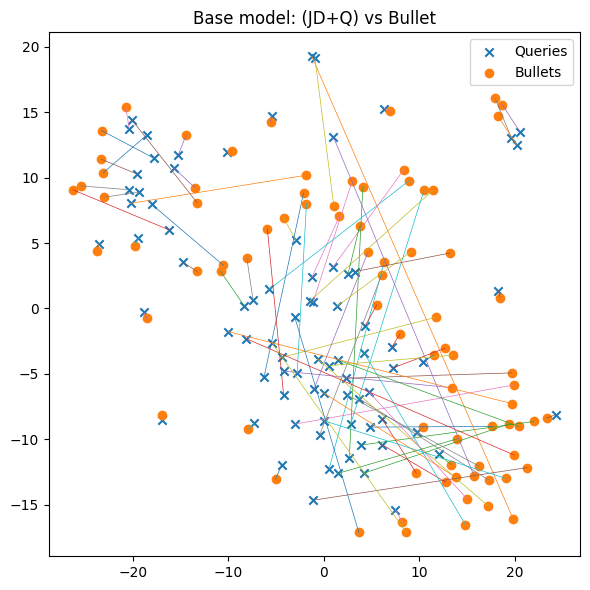

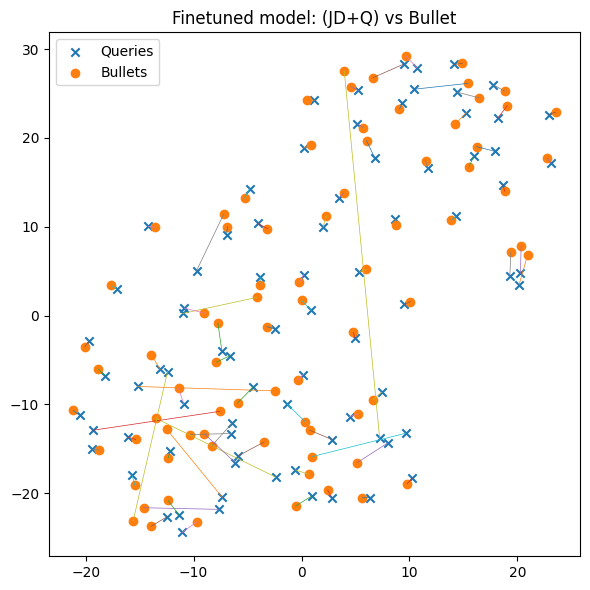

In [44]:
def plot_embedding_2d(query_2d, bullet_2d, title):
    plt.figure(figsize=(6, 6))

    # 畫 query 點
    plt.scatter(query_2d[:, 0], query_2d[:, 1], marker="x", label="Queries")
    # 畫 bullet 點
    plt.scatter(bullet_2d[:, 0], bullet_2d[:, 1], marker="o", label="Bullets")

    # 畫每個 query -> 對應 bullet 的連線
    for i in range(len(query_2d)):
        x_vals = [query_2d[i, 0], bullet_2d[i, 0]]
        y_vals = [query_2d[i, 1], bullet_2d[i, 1]]
        plt.plot(x_vals, y_vals, linewidth=0.5)

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_embedding_2d(base_query_2d, base_bullet_2d, "Base model: (JD+Q) vs Bullet")
plot_embedding_2d(ft_query_2d,   ft_bullet_2d,   "Finetuned model: (JD+Q) vs Bullet")


/var/folders/mw/qrkc_sls4y3c2hh2cgtystk40000gn/T/ipykernel_6943/1452765513.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", n)   # 最多 20 種顏色，超過會重複循環


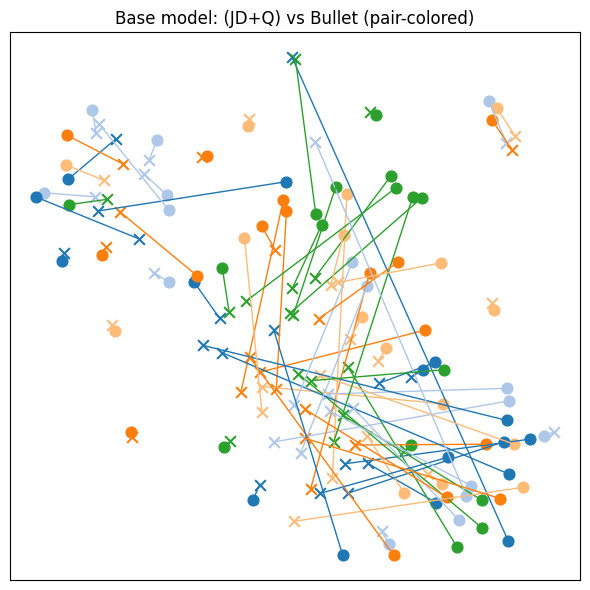

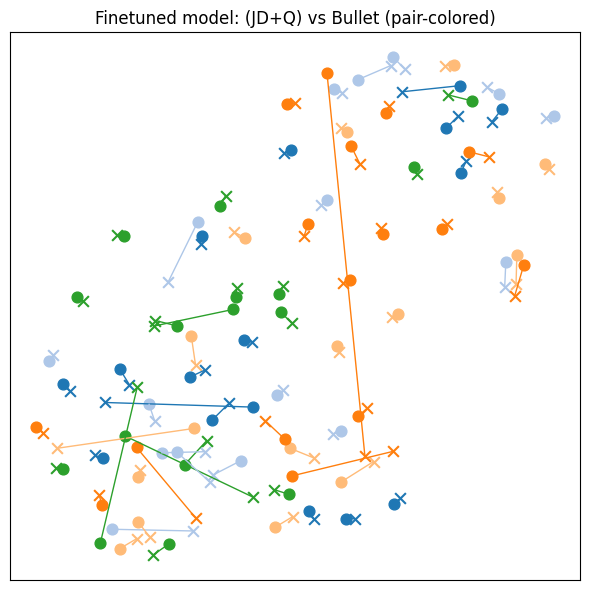

In [46]:
def plot_pairs_colored(query_2d, bullet_2d, title="(JD+Q) vs Bullet (pair-colored)"):
    """
    query_2d: shape (N, 2)
    bullet_2d: shape (N, 2)
    只畫成對的 (query_i, bullet_i)，每一對用同一個顏色。
    """
    query_2d = np.asarray(query_2d)
    bullet_2d = np.asarray(bullet_2d)
    assert query_2d.shape == bullet_2d.shape

    n = query_2d.shape[0]
    cmap = cm.get_cmap("tab20", n)   # 最多 20 種顏色，超過會重複循環

    plt.figure(figsize=(6, 6))

    for i in range(n):
        color = cmap(i % 20)

        # 畫 query (x) & bullet (o)
        plt.scatter(query_2d[i, 0],  query_2d[i, 1],
                    marker="x", color=color, s=60)
        plt.scatter(bullet_2d[i, 0], bullet_2d[i, 1],
                    marker="o", color=color, s=60)

        # 兩點之間畫線
        plt.plot(
            [query_2d[i, 0], bullet_2d[i, 0]],
            [query_2d[i, 1], bullet_2d[i, 1]],
            color=color,
            linewidth=1,
        )

    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

plot_pairs_colored(base_query_2d, base_bullet_2d,
                   title="Base model: (JD+Q) vs Bullet (pair-colored)")

plot_pairs_colored(ft_query_2d, ft_bullet_2d,
                   title="Finetuned model: (JD+Q) vs Bullet (pair-colored)")

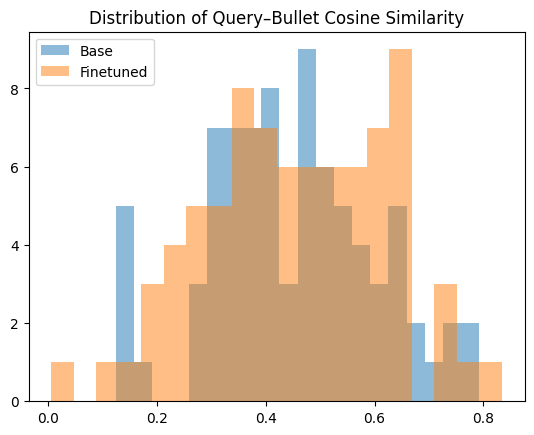

Base avg: 0.4511311
FT   avg: 0.45355815


In [47]:
def cosine_dist(a, b):
    return torch.nn.functional.cosine_similarity(
        torch.tensor(a), torch.tensor(b), dim=1
    ).numpy()

# 取同一批 pairs
text_queries = vis_merged["query_text"].tolist()
text_bullets = vis_merged["bullet_text"].tolist()

# base
base_q = base_model.encode(text_queries, convert_to_tensor=False)
base_b = base_model.encode(text_bullets, convert_to_tensor=False)
base_cos = cosine_dist(base_q, base_b)

# finetuned
ft_q = finetuned_model.encode(text_queries, convert_to_tensor=False)
ft_b = finetuned_model.encode(text_bullets, convert_to_tensor=False)
ft_cos = cosine_dist(ft_q, ft_b)

plt.hist(base_cos, alpha=0.5, bins=20, label="Base")
plt.hist(ft_cos, alpha=0.5, bins=20, label="Finetuned")
plt.title("Distribution of Query–Bullet Cosine Similarity")
plt.legend()
plt.show()

print("Base avg:", base_cos.mean())
print("FT   avg:", ft_cos.mean())

## Save FT model

In [ ]:
SAVE_DIR = Path("../models/jdq_bullet_finetuned")  # 你可以改成任何你喜歡的資料夾名稱
SAVE_DIR.mkdir(parents=True, exist_ok=True)

finetuned_model.save(str(SAVE_DIR))
print("Model saved to:", SAVE_DIR)

Model saved to: ../models/jdq_bullet_finetuned


## Load model

In [3]:
MODEL_DIR = "../models/jdq_bullet_finetuned"   # 跟剛剛 SAVE_DIR 一樣
DEVICE = "cpu"  # 或 "cuda" 如果你有 GPU

retriever_model = SentenceTransformer(MODEL_DIR, device=DEVICE)
retriever_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

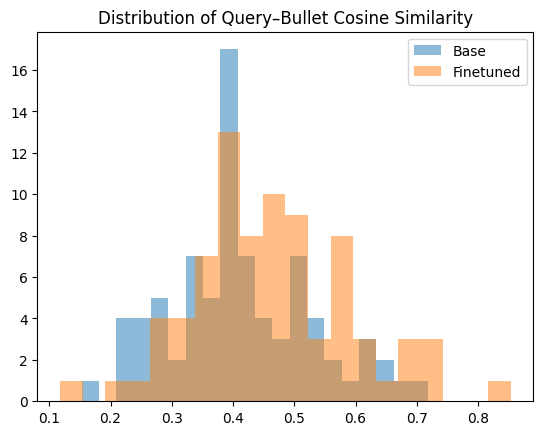

Base avg: 0.41237545
FT   avg: 0.46248645


In [13]:
def cosine_dist(a, b):
    return torch.nn.functional.cosine_similarity(
        torch.tensor(a), torch.tensor(b), dim=1
    ).numpy()

# 取同一批 pairs
text_queries = vis_merged["query_text"].tolist()
text_bullets = vis_merged["bullet_text"].tolist()

# base
base_q = base_model.encode(text_queries, convert_to_tensor=False)
base_b = base_model.encode(text_bullets, convert_to_tensor=False)
base_cos = cosine_dist(base_q, base_b)

# finetuned
ft_q = retriever_model.encode(text_queries, convert_to_tensor=False)
ft_b = retriever_model.encode(text_bullets, convert_to_tensor=False)
ft_cos = cosine_dist(ft_q, ft_b)

plt.hist(base_cos, alpha=0.5, bins=20, label="Base")
plt.hist(ft_cos, alpha=0.5, bins=20, label="Finetuned")
plt.title("Distribution of Query–Bullet Cosine Similarity")
plt.legend()
plt.show()

print("Base avg:", base_cos.mean())
print("FT   avg:", ft_cos.mean())

In [16]:
baseline = evaluate_jd_plus_question_to_bullet(
    base_model,
    bullets_df_test,
    q_df_test
)

finetuned = evaluate_jd_plus_question_to_bullet(
    retriever_model,
    bullets_df_test,
    q_df_test
)

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:19<00:00, 62.26it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.1836, Precision@k=0.1836
k=3: Hit@k=0.2971, Precision@k=0.0990
k=5: Hit@k=0.3510, Precision@k=0.0702
k=10: Hit@k=0.4227, Precision@k=0.0423


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Eval (JD + question) -> bullet: 100%|██████████| 1242/1242 [00:18<00:00, 65.75it/s]

=== Retrieval: (JD + question) -> bullet ===
k=1: Hit@k=0.4026, Precision@k=0.4026
k=3: Hit@k=0.6063, Precision@k=0.2021
k=5: Hit@k=0.6852, Precision@k=0.1370
k=10: Hit@k=0.7915, Precision@k=0.0791


In [17]:
ks = sorted(baseline.keys())
rows = []
for k in ks:
    rows.append({
        "k": k,
        "baseline_Hit@k": baseline[k]["Hit@k"],
        "baseline_P@k":   baseline[k]["Precision@k"],
        "ft_Hit@k":       finetuned[k]["Hit@k"],
        "ft_P@k":         finetuned[k]["Precision@k"],
    })

results_df = pd.DataFrame(rows)
results_df

,k,baseline_Hit@k,baseline_P@k,ft_Hit@k,ft_P@k
0,1,0.183575,0.183575,0.402576,0.402576
1,3,0.297101,0.099034,0.606280,0.202093
2,5,0.351047,0.070209,0.685185,0.137037
3,10,0.422705,0.042271,0.791465,0.079147


In [26]:
m = retriever_model

s1 = "Can you describe a situation where you had to lead a team through a challenging data science project, and what strategies you used to keep everyone aligned and motivated throughout the process?"
s2 = "Applied NLP (NLTK), LLMs (OpenAI API, Transformers) and ML (scikit-learn) models to analyze verbal, nonverbal, and questionnaire data, achieving 80 percent accuracy on stance classification"
e = m.encode([s1, s2])
print(e.shape)
print("cosine:", (e[0] @ e[1]) / (np.linalg.norm(e[0]) * np.linalg.norm(e[1])))

(2, 384)
cosine: 0.11558553


In [20]:
s3 = "I enjoy watching basketball game."

e = m.encode([s1, s3])
print(e.shape)
print("cosine:", (e[0] @ e[1]) / (np.linalg.norm(e[0]) * np.linalg.norm(e[1])))

(2, 384)
cosine: 0.82364553


In [21]:
b = base_model
s1 = "I love playing basketball."
s2 = "I enjoy cooking Italian food."

e = b.encode([s1, s2])
print(e.shape)
print("cosine:", (e[0] @ e[1]) / (np.linalg.norm(e[0]) * np.linalg.norm(e[1])))

(2, 384)
cosine: 0.34019315


In [22]:
s3 = "I enjoy watching basketball game."

e = b.encode([s1, s3])
print(e.shape)
print("cosine:", (e[0] @ e[1]) / (np.linalg.norm(e[0]) * np.linalg.norm(e[1])))

(2, 384)
cosine: 0.818976
